In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
vaccinations = pd.read_csv('/content/drive/MyDrive/dataset/country_vaccinations.csv')
vaccinations.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.00,0.00,nan,nan,nan,0.00,0.00,nan,nan,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,nan,nan,nan,nan,1367.00,nan,nan,nan,35.00,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,nan,nan,nan,nan,1367.00,nan,nan,nan,35.00,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,nan,nan,nan,nan,1367.00,nan,nan,nan,35.00,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,nan,nan,nan,nan,1367.00,nan,nan,nan,35.00,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


In [4]:
vaccinations = vaccinations[['date', 
                             'country', 
                             'iso_code', 
                             'daily_vaccinations', 
                             'people_vaccinated_per_hundred',
                             'vaccines',
                            ]]

In [5]:
vaccinations.select_dtypes(include=['object']).isnull().sum()

date        0
country     0
iso_code    0
vaccines    0
dtype: int64

In [6]:
vaccinations.loc[vaccinations.iso_code.isnull(), 'country'].value_counts()

Series([], Name: country, dtype: int64)

In [7]:
vaccinations.loc[vaccinations.country == 'United Kingdom', 'iso_code'].unique()

array(['GBR'], dtype=object)

In [8]:
vaccinations.loc[vaccinations.country.isin(['England', 'Scotland', 'Wales', 'Northern Ireland']), 'iso_code'] = 'GBR'

In [9]:
continents = pd.read_csv('/content/drive/MyDrive/dataset/continents.csv')
continents.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.00,34.00,nan
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.00,154.00,nan
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.00,39.00,nan
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.00,15.00,nan
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.00,61.00,nan


In [10]:
data = vaccinations.merge(continents[['alpha-3', 'region', 'sub-region']],
                          how='left',
                          left_on = 'iso_code',
                          right_on = 'alpha-3',
                         ).drop(columns=['alpha-3'])
data.head()

,date,country,iso_code,daily_vaccinations,people_vaccinated_per_hundred,vaccines,region,sub-region
0,2021-02-22,Afghanistan,AFG,nan,0.00,Oxford/AstraZeneca,Asia,Southern Asia
1,2021-02-23,Afghanistan,AFG,1367.00,nan,Oxford/AstraZeneca,Asia,Southern Asia
2,2021-02-24,Afghanistan,AFG,1367.00,nan,Oxford/AstraZeneca,Asia,Southern Asia
3,2021-02-25,Afghanistan,AFG,1367.00,nan,Oxford/AstraZeneca,Asia,Southern Asia
4,2021-02-26,Afghanistan,AFG,1367.00,nan,Oxford/AstraZeneca,Asia,Southern Asia


In [11]:
data.columns = ['date', 'country', 'iso_code', 'daily_vaccinations', 'people_vaccinated_per_hundred', 'vaccines', 
                'continent', 'region']

In [12]:
data.continent.value_counts()

Europe      6063
Asia        3822
Americas    3508
Africa      1869
Oceania      277
Name: continent, dtype: int64

In [13]:
data.loc[data.region == 'Northern America', 'continent'] = 'North America'
data.loc[data.region == 'Latin America and the Caribbean', 'continent'] = 'South America'

In [14]:
data[data.continent == 'Oceania'].country.value_counts()

Australia           81
New Zealand         76
Solomon Islands     36
Fiji                31
Papua New Guinea    28
Tonga               13
Nauru                8
Samoa                4
Name: country, dtype: int64

In [15]:
data.isnull().sum()

date                                0
country                             0
iso_code                            0
daily_vaccinations                201
people_vaccinated_per_hundred    6912
vaccines                            0
continent                         127
region                            127
dtype: int64

In [16]:
data.loc[data.continent.isnull(), 'iso_code'].value_counts()

OWID_CYN    100
OWID_KOS     27
Name: iso_code, dtype: int64

In [17]:
data[data.country.isin(['Cyprus', 'Turkey'])][['continent', 'region']].drop_duplicates()

,continent,region
3387,Asia,Western Asia


In [18]:
data.loc[data.country == 'Northern Cyprus', 'continent'] = 'Asia'
data.loc[data.country == 'Northern Cyprus', 'region'] = 'Western Asia'

In [19]:
data.loc[data.daily_vaccinations.isnull(), 'country'].value_counts()

Guinea          3
Sierra Leone    2
Oman            2
Guyana          2
Russia          1
               ..
Czechia         1
Malta           1
Saint Lucia     1
Jersey          1
Bangladesh      1
Name: country, Length: 196, dtype: int64

In [20]:
data.loc[data.daily_vaccinations.isnull(), 'date'].value_counts().head()

2020-12-27    13
2020-12-28     8
2021-03-01     6
2021-02-22     6
2021-01-03     5
Name: date, dtype: int64

In [21]:
data.loc[data.people_vaccinated_per_hundred.isnull()].shape[0] / data.shape[0]

0.4412102642665645

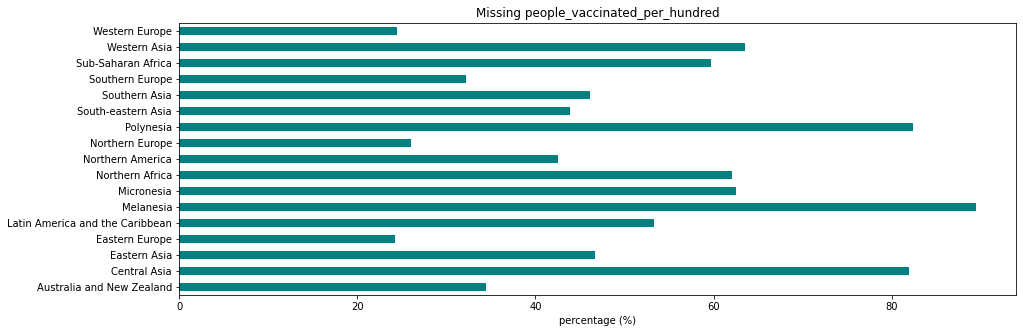

In [22]:
(
    data[data.people_vaccinated_per_hundred.isnull()].region.value_counts() / data.region.value_counts()
).mul(100).plot.barh(color="teal", figsize=(15,5))

plt.title('Missing people_vaccinated_per_hundred')
plt.xlabel('percentage (%)')
plt.show()

In [23]:
data.sort_values(by='date', inplace=True)
all_countries = list(data.country.unique())

for country in all_countries:
    data.loc[data.country == country, 'people_vaccinated_per_hundred'] = \
    data.loc[data.country == country, 'people_vaccinated_per_hundred'].fillna(method='bfill').fillna(method='ffill')

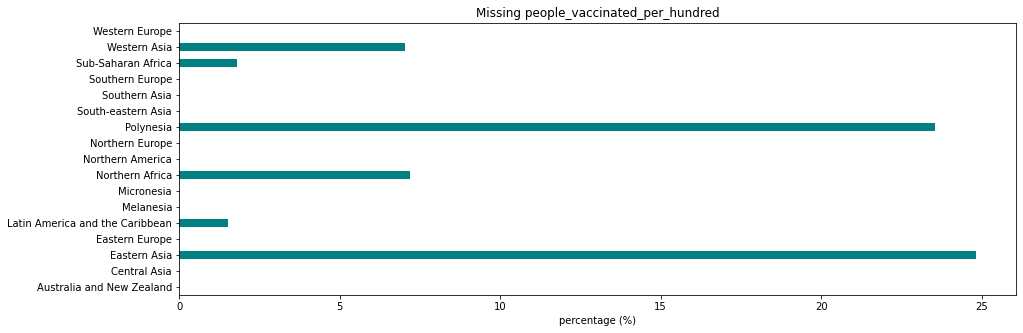

In [24]:
(
    data[data.people_vaccinated_per_hundred.isnull()].region.value_counts() / data.region.value_counts()
).mul(100).plot.barh(color="teal", figsize=(15,5))

plt.title('Missing people_vaccinated_per_hundred')
plt.xlabel('percentage (%)')
plt.show()

In [25]:
data.vaccines.value_counts()

Oxford/AstraZeneca                                                                    2607
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                          2389
Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                         1532
Oxford/AstraZeneca, Pfizer/BioNTech                                                   1418
Pfizer/BioNTech                                                                       1227
Moderna, Pfizer/BioNTech                                                               604
Oxford/AstraZeneca, Sinopharm/Beijing                                                  587
Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac                                           499
Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V                      487
Oxford/AstraZeneca, Sinovac                                                            472
Sputnik V                                                                              438

In [26]:
df = data[['iso_code', 'vaccines']].drop_duplicates()
df.shape

(192, 2)

In [27]:
data.iso_code.unique().shape

(192,)

In [28]:
map_plot_df = pd.concat([pd.Series(row['iso_code'], row['vaccines'].split(','))              
                         for _, row in df.iterrows()]).reset_index()

#rename columns
map_plot_df.columns = ['vaccine', 'iso_code']

#strip white spaces
map_plot_df['vaccine'] = map_plot_df['vaccine'].str.strip(' ')

map_plot_df.vaccine.value_counts()

Oxford/AstraZeneca    142
Pfizer/BioNTech        88
Moderna                38
Sinopharm/Beijing      38
Sputnik V              32
Sinovac                24
Johnson&Johnson        14
CanSino                 2
Sinopharm/Wuhan         2
EpiVacCorona            1
Covaxin                 1
Name: vaccine, dtype: int64

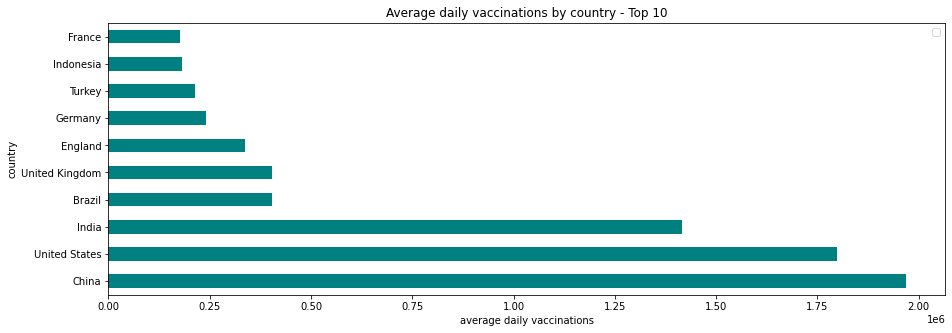

In [29]:
data.groupby(['country']).agg({'daily_vaccinations':'mean'}).sort_values(by='daily_vaccinations', ascending=False)[:10].plot.barh(color="teal", figsize=(15,5))
plt.title('Average daily vaccinations by country - Top 10')
plt.legend('')
plt.xlabel('average daily vaccinations')
plt.show()

In [30]:
def plot_daily_vaccination_data(data, region_column, regions_list, vaccination_metric, plot_title, min_date = '2020-12-13', max_date='2021-02-13'):
    '''
    Plots a vaccination metric using Plotly library
    
    INPUT 
        data : Pandas dataframe
            a dataframe holding the data to be plotted 
            must contain a date column (unique dates), a region column and a vaccination related metric
        region_column : string
            name of the region column 
            (continent/region/country)
        regions_list : list
            list of strings with regions to be plotted
            must contain values of region_column
        vaccination_metric : string
            name of the vaccination metric column 
            (daily_vaccinations/people_fully_vaccinated_per_hundred)
        plot_title : string 
            the title of your plot
        min_date : string
            lower date limit for the plot
        max_date : string
            upper date limit for the plot
    '''
    df = data[(data[region_column].isin(regions_list)) & (data.date <= max_date) & (data.date >= min_date)]
    fig = px.line(df, 
                  x = 'date', 
                  y = vaccination_metric,
                  color = region_column,
                  title = plot_title
                 )
    fig.show()

In [31]:
continents_daily_df = data.groupby(['date', 'continent']).agg({'daily_vaccinations':'sum',
                                                               'people_vaccinated_per_hundred':'mean',
                                                              }).reset_index()
regions_daily_df = data.groupby(['date', 'region']).agg({'daily_vaccinations':'sum',
                                                         'people_vaccinated_per_hundred':'mean',
                                                        }).reset_index()

In [32]:
all_continents = list(continents_daily_df.continent.unique())
all_regions = list(regions_daily_df.region.unique())

In [33]:
plot_daily_vaccination_data(data = continents_daily_df,  
                            region_column = 'continent',
                            regions_list = all_continents,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Continent in the first three months',
                            min_date = '2020-12-13',
                            max_date = '2021-02-13'
                           )

In [34]:
print('Maximum vaccinations in a day in a country - summary per continent: \n====================================================================')
for continent in all_continents:
    df = data[data.continent == continent].sort_values(by=['daily_vaccinations'], ascending=False).iloc[0]
    print(f'\t{df.continent} -> {round(int(df.daily_vaccinations)/1000000,2)} million vaccinations in {df.country} on {df.date}')

Maximum vaccinations in a day in a country - summary per continent: 
	North America -> 3.38 million vaccinations in United States on 2021-04-13
	Asia -> 7.21 million vaccinations in China on 2021-05-02
	Europe -> 0.67 million vaccinations in Germany on 2021-05-04
	South America -> 1.14 million vaccinations in Brazil on 2021-04-13
	Africa -> 0.21 million vaccinations in Morocco on 2021-03-16
	Oceania -> 0.06 million vaccinations in Australia on 2021-04-24


In [35]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = all_regions,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Region',
                            min_date = '2020-12-13',
                            max_date = '2021-02-13'
                           )

In [36]:
print('Maximum vaccinations in a country in a day - summary per region: \n================================================================')
for region in all_regions:
    df = data[data.region == region].sort_values(by=['daily_vaccinations'], ascending=False).iloc[0]
    print(f'\t{df.region} -> {round(int(df.daily_vaccinations)/1000000,4)} million vaccinations in {df.country} on {df.date}')


Maximum vaccinations in a country in a day - summary per region: 
	Northern America -> 3.3844 million vaccinations in United States on 2021-04-13
	Eastern Asia -> 7.2053 million vaccinations in China on 2021-05-02
	Eastern Europe -> 0.3452 million vaccinations in Russia on 2021-03-29
	Western Asia -> 0.4356 million vaccinations in Turkey on 2021-02-18
	Western Europe -> 0.6745 million vaccinations in Germany on 2021-05-04
	Latin America and the Caribbean -> 1.1358 million vaccinations in Brazil on 2021-04-13
	Northern Europe -> 0.6023 million vaccinations in United Kingdom on 2021-03-21
	Southern Europe -> 0.4513 million vaccinations in Italy on 2021-05-05
	Sub-Saharan Africa -> 0.0689 million vaccinations in Nigeria on 2021-04-01
	South-eastern Asia -> 0.4493 million vaccinations in Indonesia on 2021-03-23
	Southern Asia -> 3.6594 million vaccinations in India on 2021-04-10
	Northern Africa -> 0.209 million vaccinations in Morocco on 2021-03-16
	Central Asia -> 0.0952 million vaccinat

In [37]:
Europe = ['Northern Europe', 'Eastern Europe', 'Western Europe', 'Southern Europe']
Asia = ['Eastern Asia', 'Western Asia', 'South-eastern Asia', 'Southern Asia']
Africa = ['Sub-Saharan Africa', 'Northern Africa']
Americas = ['Northern America', 'Latin America and the Caribbean']

In [38]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = Europe,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Region in Europe'
                           )

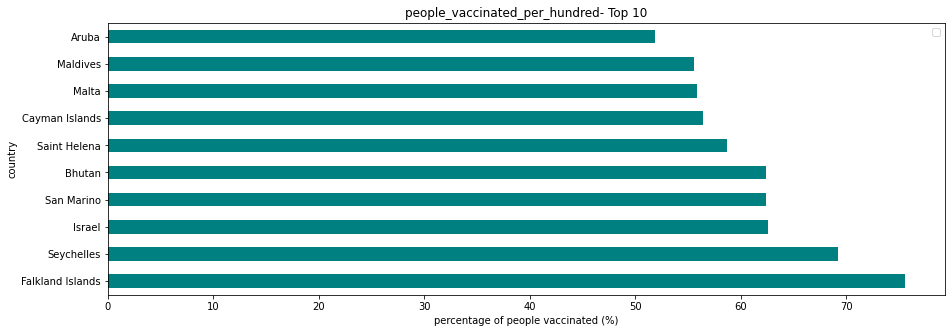

In [39]:
uk_countries = ['England', 'Scotland', 'Wales', 'Northern Ireland', 'Jersey', 'Isle of Man', 'Bermuda', 'Gibraltar']
data[~data.country.isin(uk_countries)].groupby(['country']).agg({'people_vaccinated_per_hundred':'max'}).sort_values(by='people_vaccinated_per_hundred', ascending=False)[:10].plot.barh(color="teal", figsize=(15,5))
plt.title('people_vaccinated_per_hundred- Top 10')
plt.legend('')
plt.xlabel('percentage of people vaccinated (%)')
plt.show()

In [40]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = Europe + ['Northern America'],
                            vaccination_metric = 'people_vaccinated_per_hundred',
                            plot_title = 'people_vaccinated_per_hundred evolution in the first three months',
                           )